In [2]:

    from IPython.display import clear_output
    from time import sleep, time

    import itertools
    from collections import defaultdict
    import matplotlib.pyplot as plt
    import matplotlib
    from matplotlib.colors import rgb2hex
    import seaborn as sns
    import numpy as np
    from nuscenes.nuscenes import NuScenes
    from nuscenes.utils.data_classes import LidarPointCloud, Box
    from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix , points_in_box as nusc_points_in_box
    from nuscenes.nuscenes import NuScenesExplorer
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    import multiprocessing
    import subprocess
    from pyquaternion import Quaternion
    from sklearn import linear_model
    # from shapely.geometry import box as shapelybox, Point

In [4]:

    DATASET_DIR = "../../../Dataset/nuscenes"
    nusc = NuScenes(version="v1.0-mini", dataroot=DATASET_DIR)



Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.5 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [6]:
    scene_index=None
    my_scene = None
    sample_token = None
    sample_tokens = None
    sample_records = None

    def change_scene(index=-3):
        global scene_index
        global my_scene
        global sample_token
        global sample_tokens
        global sample_records
        scene_index = index
        my_scene = nusc.scene[scene_index]

        sample_token = my_scene['first_sample_token']
        sample_tokens = []
        sample_records = []
        for i in range(my_scene['nbr_samples']):
            sample_tokens.append(sample_token)
            sample_records.append(nusc.get('sample', sample_token))
            sample_token = sample_records[-1]['next']

    def token2num(token, num_digits=2):
        return abs(hash(token)) % (10 ** num_digits)

    change_scene(index=-4)



In [7]:
    class KalmanFilter:

        const_velo_F = lambda t: np.array([[1, 0, t, 0], # Transition matrix for two dimentional constant velocity model
                                           [0, 1, 0, t],
                                           [0, 0, 1, 0],
                                           [0, 0, 0, 1]])
        position_meas_H = np.array([[1, 0, 0, 0],
                                    [0, 1, 0, 0]])
        def transition_err_Q(t):
            sigma = 1
            vec = np.array([[.5 * t**2, .5 * t**2, t, t]])
            return sigma * np.matmul(vec.transpose(), vec)

        def __init__(self, 
                     X_len=4, 
                     Y_len=2,
                     H=np.array([[1, 0, 0, 0],
                                 [0, 1, 0, 0]]),
                     F=const_velo_F,
                     Q=transition_err_Q,
                     R=1 * np.array([[1, 0], 
                                     [0, 1]]),
                     X_0 = np.array([0, 0, 1, 1]),
                     C_xx_0 = np.array([[1, 0, 0, 0],
                                        [0, 1, 0, 0],
                                        [0, 0, 1, 0],
                                        [0, 0, 0, 1]])):
            self.X = X_0
            self.C_xx = C_xx_0
            self.H = H
            self.F = F
            self.Q = Q
            self.R = R

        def time_update(self, 
                        delta_t):
            F = self.F(delta_t)
            self.X = np.matmul(F, self.X)
            self.C_xx = np.matmul(F, np.matmul(self.C_xx, F.transpose())) + self.Q(delta_t)

        def measurement_update(self, 
                               Y):
            H_T = self.H.transpose()
            S = np.matmul(self.H, np.matmul(self.C_xx, H_T)) + self.R

            K = np.matmul(self.C_xx, np.matmul(H_T, np.linalg.inv(S)))
            K_T = K.transpose()
            self.X = self.X + np.matmul(K, (Y - np.matmul(self.H, self.X)))
            self.C_xx = self.C_xx - np.matmul(K, np.matmul(S, K_T))

        def update(self, delta_t, Y):
            self.time_update(delta_t)
            self.measurement_update(Y)
            return self.X



In [14]:
    # print(sample_tokens)
    # print(my_scene)
    # sd_record = nusc.get('sample_data', my_scene)
    # nusc.render_sample_data(my_scene['first_sample_token']['data']['LIDAR_TOP'])

    IMG_DIR = "pics/"
    VIDEO_DIR = "videos/"
    SCENE_INDEX_PREFIX="_scene_"
    VIDEO_FILETYPE_EXTENSION=".mp4"
    SAMPLE_TOKEN_PREFIX="_sample_token_"
    IMAGE_FILETYPE_EXTENSION= ".png"
    PLT_WIDTH=100
    PLT_HEIGHT=100

    def get_filename(scene_index,sample_token,index):
        return IMG_DIR+SCENE_INDEX_PREFIX+str(scene_index)+SAMPLE_TOKEN_PREFIX+str(index).zfill(4)+IMAGE_FILETYPE_EXTENSION

    def render_sample(sample_token_index, 
                      point_scale=1, 
                      xlim=[-50, 50], 
                      ylim=[-50, 50], 
                      xlim3d=[-10, 10], 
                      ylim3d=[-10, 10],
                      zlim3d=[0, 5],
                      azim=-130,
                      elev=20,
                      plot_all=False,
                      alpha=0.1,
                      dpi=100,
                      subsample=None,
                      show=True,
                      d3=False,
                      box_output=(lambda box, sample_annotation, sample_timestamp, num_boxes, boxi, ax, d3: 1),
                      only_these_boxes=None):

        fig = plt.figure(dpi=dpi)
        if d3:
            ax = fig.add_subplot(1, 1, 1, projection='3d')
            ax.set_xlim3d(xlim3d[0], xlim3d[1])
            ax.set_ylim3d(ylim3d[0], ylim3d[1])
            ax.set_zlim3d(zlim3d[0], zlim3d[1])
            ax.view_init(azim=azim, elev=elev)

        else:
            ax = fig.add_subplot(1, 1, 1)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            # plt.axis('off')
            ax.set_facecolor("white")
            # fig.clf()
        sample_token = sample_tokens[sample_token_index]
        sample_timestamp = 1e-6 * nusc.get('sample', sample_token)['timestamp']
        sample_record = sample_records[sample_token_index]
        sd_record = nusc.get('sample_data', sample_record['data']['LIDAR_TOP'])
        # nusc.render_sample_data(sample_record['data']['LIDAR_TOP'])
        sample_rec = nusc.get('sample', sd_record['sample_token'])
        chan = sd_record['channel']
        ref_chan = 'LIDAR_TOP'
        ref_sd_token = sample_rec['data'][ref_chan]
        ref_sd_record = nusc.get('sample_data', ref_sd_token)
        pc, times = LidarPointCloud.from_file_multisweep(nusc=nusc,sample_rec=sample_rec, chan=chan, ref_chan=ref_chan, nsweeps=1)
        velocities=None
        cs_record = nusc.get('calibrated_sensor', ref_sd_record['calibrated_sensor_token'])
        pose_record = nusc.get('ego_pose', ref_sd_record['ego_pose_token'])
        ref_to_ego = transform_matrix(translation=cs_record['translation'],
                                      rotation=Quaternion(cs_record["rotation"]))
        ego_yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
        rotation_vehicle_flat_from_vehicle = np.dot(Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
                                                    Quaternion(pose_record['rotation']).inverse.rotation_matrix)
        vehicle_flat_from_vehicle = np.eye(4)
        vehicle_flat_from_vehicle[:3, :3] = rotation_vehicle_flat_from_vehicle
        viewpoint = np.dot(vehicle_flat_from_vehicle, ref_to_ego)

        points_ = view_points(pc.points[:3, :], viewpoint, normalize=False)
        nbr_points = len(points_[0])
        if subsample:
            print("Subsampling")
            subsample_indices = np.random.choice(nbr_points, int(nbr_points * subsample))
            points = np.array([points_[0][subsample_indices], 
                               points_[1][subsample_indices], 
                               points_[2][subsample_indices]])
        else:
            subsample_indices = np.arange(nbr_points)
            points = points_.copy()
        dists = np.sqrt(np.sum(pc.points[:2, :] ** 2, axis=0))
        colors = np.minimum(1, dists / 40 / np.sqrt(2))

        if d3:
            if plot_all:
                scatter3d2 = ax.scatter(points[0, :], 
                                        points[1, :], 
                                        points[2, :], 
                                        color='red', 
                                        s=point_scale, 
                                        marker='.',
                                        alpha=alpha)
            ax.plot([0], [0], [0],'x', color='red')

        # print(colors[subsample_indices][outlier_mask].shape, outlier_points[0, :].shape)
        else:
            if plot_all:
                scatter22 = ax.scatter(points[0, :], 
                                       inlier_points[1, :], 
                                       s=point_scale,
                                       color="red",
                                       alpha=alpha, 
                                       marker=',')
                # scatter = ax.scatter(outlier_points[0, :], outlier_points[1, :], s=point_scale, color="blue"# c=matplotlib.cm.winter(colors[subsample_indices][np.where(outlier_mask)])
                #                      , alpha=.3, marker=",")

            ax.plot(0, 0, 'x', color='red')
        _, boxes, _ = nusc.get_sample_data(ref_sd_token, box_vis_level=BoxVisibility.ANY,
                                           use_flat_vehicle_coordinates=True)


        def render_box(ax, box, colors):
            corners = box.corners()
            # lines = np.array(list(itertools.combinations(corners.transpose(),2)))
            # for line in lines:
            #     ax.plot(line[:,0], line[:,1], line[:,2], color='green')
            point_pairs = [(0,1),
                           (1,2),
                           (2,3),
                           (3,0),
                           (4,5),
                           (5,6),
                           (6,7),
                           (7,4),

                           (0,4),
                           (1,5),
                           (2,6),
                           (3,7)]


            for point_pair in point_pairs:
                # print(corners[0][i], corners[1][i], corners[2][i])
                ax.plot([corners[0][point_pair[0]], corners[0][point_pair[1]]],
                        [corners[1][point_pair[0]], corners[1][point_pair[1]]],
                        [corners[2][point_pair[0]], corners[2][point_pair[1]]],
                        color='green', s=0.1)


        for boxi, box in enumerate(boxes):

            sample_annotation = nusc.get("sample_annotation", box.token)

            c = np.array(NuScenesExplorer.get_color(box.name)) / 255.0
            actual_points_in_box = np.where(nusc_points_in_box(box, points))

            box.render(ax, view=np.eye(4), colors=(c, c, c), linewidth=0.3)

            if only_these_boxes is not None and sample_annotation["instance_token"] not in only_these_boxes:
                continue
            box.inlier_points = points[:,actual_points_in_box]
            if d3:
                # render_box(ax=ax, box=box, colors=(c, c, c))     

                ax.scatter(points[0, actual_points_in_box], 
                           points[1, actual_points_in_box], 
                           points[2, actual_points_in_box], marker='.', color = rgb2hex(plt.get_cmap(name="tab20", lut=100)(token2num(sample_annotation["instance_token"]))))
                # ax.plot(box.center[0], box.center[1], '.', color='blue', linewidth=0.000)
            else:
                ax.scatter(points[0, actual_points_in_box], 
                           points[1, actual_points_in_box], 
                           marker='.', s=point_scale, alpha=0.3, color = rgb2hex(plt.get_cmap(name="tab20", lut=100)(token2num(sample_annotation["instance_token"]))))
            box_output(box, sample_annotation, sample_timestamp, len(boxes), boxi, ax, d3)
            # points = points[:, not actual_points_in_box]

        # fig.text(.1, .075, "False Positives")
        # fig.text(.1, .04, "[sum, perc] : "+str([sum_ransac_false_positives, perc_ransac_false_positives]))
        # fig.text(.5,.05, "sample_index:"+str(sample_token_index))
        plt.draw()
        plt.savefig(get_filename(scene_index, sample_token, sample_token_index))
        if show:
            plt.show()
        fig.clear()
        plt.close(fig)
        print("rendered sample_token_index "+str(sample_token_index))

    def render_scene(*args, **kwargs):
        plt.figure(1).suptitle(my_scene['description'])
        for i in range(my_scene['nbr_samples']):
            render_sample(i, *args, **kwargs)

    def render_scene_parallel(*args, **kwargs):
        jpbs = []
        for i in range(my_scene['nbr_samples']):
            p = multiprocessing.Process(target=render_sample, args=[i]+list(args), kwargs=kwargs)
            p.start()


    def png2mp4(si=None):
        if not si:
            si = scene_index
        image_command = IMG_DIR+SCENE_INDEX_PREFIX+str(si)+SAMPLE_TOKEN_PREFIX+"%4d"+IMAGE_FILETYPE_EXTENSION
        video_command = VIDEO_DIR+SCENE_INDEX_PREFIX+str(si)+VIDEO_FILETYPE_EXTENSION
        subprocess.run(["ffmpeg",
                        "-r:v",
                        "5",
                        "-i",
                        image_command,
                        "-codec:v",
                        "libx264",
                        "-preset",
                        "veryslow",
                        "-pix_fmt",
                        "yuv420p",
                        "-crf",
                        "28",
                        video_command])

    def sort_instances_measured(annots={}, return_keys=True):
        sorted_stuff = sorted(annots.items(), key=lambda x:len(x[1]["Annotations"]))
        if return_keys==True:
            return [x[0] for x in sorted_stuff]
        return dict(sorted_stuff)

    def filter_instances_measured(function=lambda x:len(x[1]["Annotations"])>10,
                                 annots={},
                                 return_keys=True):
        filtered_stuff = list(filter(function, annots.items()))
        if return_keys==True:
            return [x[0] for x in filtered_stuff]
        return dict(filtered_stuff)





In [10]:

    def animate_scene(wait=.5 , *args, **kwargs):
        %matplotlib inline
        plt.figure(1).suptitle(my_scene['description'])
        for i in range(my_scene['nbr_samples']):
            render_sample(i, *args, **kwargs)
            sleep(wait)
            clear_output(wait=True)


In [11]:
     def predict_position_and_velocity(*args, transition_error_sigma=1e-6, measurement_error_sigma=1e-2, **kwargs):
         def transition_err_Q(t):
             sigma = transition_error_sigma
             vec = np.array([[.5 * t**2, .5 * t**2, t, t]])
             return sigma * np.matmul(vec.transpose(), vec)

         def default_annot_obj():
             kl = KalmanFilter(R=measurement_error_sigma * np.array([[1, 0],
                                               [0, 1]]),
                               Q=transition_err_Q,
                               X_0 = np.array([[0, 0, 0, 0]]).transpose(),
                               C_xx_0 = np.array([[1e-4, 0, 0, 0],
                                                  [0, 1e-4, 0, 0],
                                                  [0, 0, 1e-4, 0],
                                                  [0, 0, 0, 1e-4]]))

             return {"KalmanFilter":kl,
                     "Annotations":[],
                     "MeasurementTimeStamps":[],
                     "MeasurementTimeDeltas":[],
                     "Measurements":[],
                     "Actuals":[],
                     "Predictions":[]# ,
                     # "TimeCorrectedMeasurements":[],
                     # "TimeCorrectedPredictions":[]
             }
         annots = defaultdict(default_annot_obj)
         def box_output(box, sample_annotation, sample_timestamp, num_boxes, boxi,  ax, d3):
             instance_token = sample_annotation["instance_token"]
             if box.inlier_points.shape[2] == 0:
                 return
             box_points = box.inlier_points[:2,0,:]

             y = box_points.mean(axis=1)
             measurement = np.array([y[:2]]).transpose()

             actual_position = np.array([box.center[0], box.center[1]])

             if annots[instance_token]["Measurements"]:
                 delta_t = sample_timestamp - annots[instance_token]["MeasurementTimeStamps"][-1]
                 actual_velocity = delta_t * (actual_position - annots[instance_token]["Actuals"][-1][:2])
             else:
                 delta_t = 0
                 actual_velocity = np.array([0, 0])
                 init_x = np.expand_dims(np.append(measurement, actual_velocity), axis=1)
                 annots[instance_token]["KalmanFilter"].X = init_x
             actuals = np.append(actual_position, actual_velocity)



             annots[instance_token]["Annotations"].append(sample_annotation)
             annots[instance_token]["MeasurementTimeStamps"].append(sample_timestamp)
             annots[instance_token]["MeasurementTimeDeltas"].append(delta_t)
             annots[instance_token]["Measurements"].append(measurement)
             annots[instance_token]["Actuals"].append(actuals)
             prediction = annots[instance_token]["KalmanFilter"].update(delta_t, measurement)
             annots[instance_token]["Predictions"].append(prediction)




             ax.scatter(measurement[0][0], measurement[1][0], marker='x', color = "black", s=1, alpha=1)
             # ax.scatter(box.center[0], box.center[1], marker=".", color = rgb2hex(plt.get_cmap(name="tab20", lut=100)(token2num(sample_annotation["instance_token"]))))
             ax.plot([measurement[0][0], box.center[0]], [measurement[1][0], box.center[1]], marker=",", color = "black", linewidth=0.3, alpha=.5)

             ax.scatter(prediction[0][0], prediction[1][0], marker=',', color = "red", s=1)
             ax.plot([prediction[0][0], box.center[0]], [prediction[1][0], box.center[1]], marker=",", color = "black", linewidth=0.3, alpha=.5)


             ax.arrow(*actuals, linewidth=0.1, width=.3, color= "green", alpha=.5)

             ax.arrow(*prediction[:,0], linewidth=0.1, width=.3, color= "red", alpha=.5)
         animate_scene(*args, box_output=box_output, **kwargs)
         return annots



In [30]:
change_scene(3)

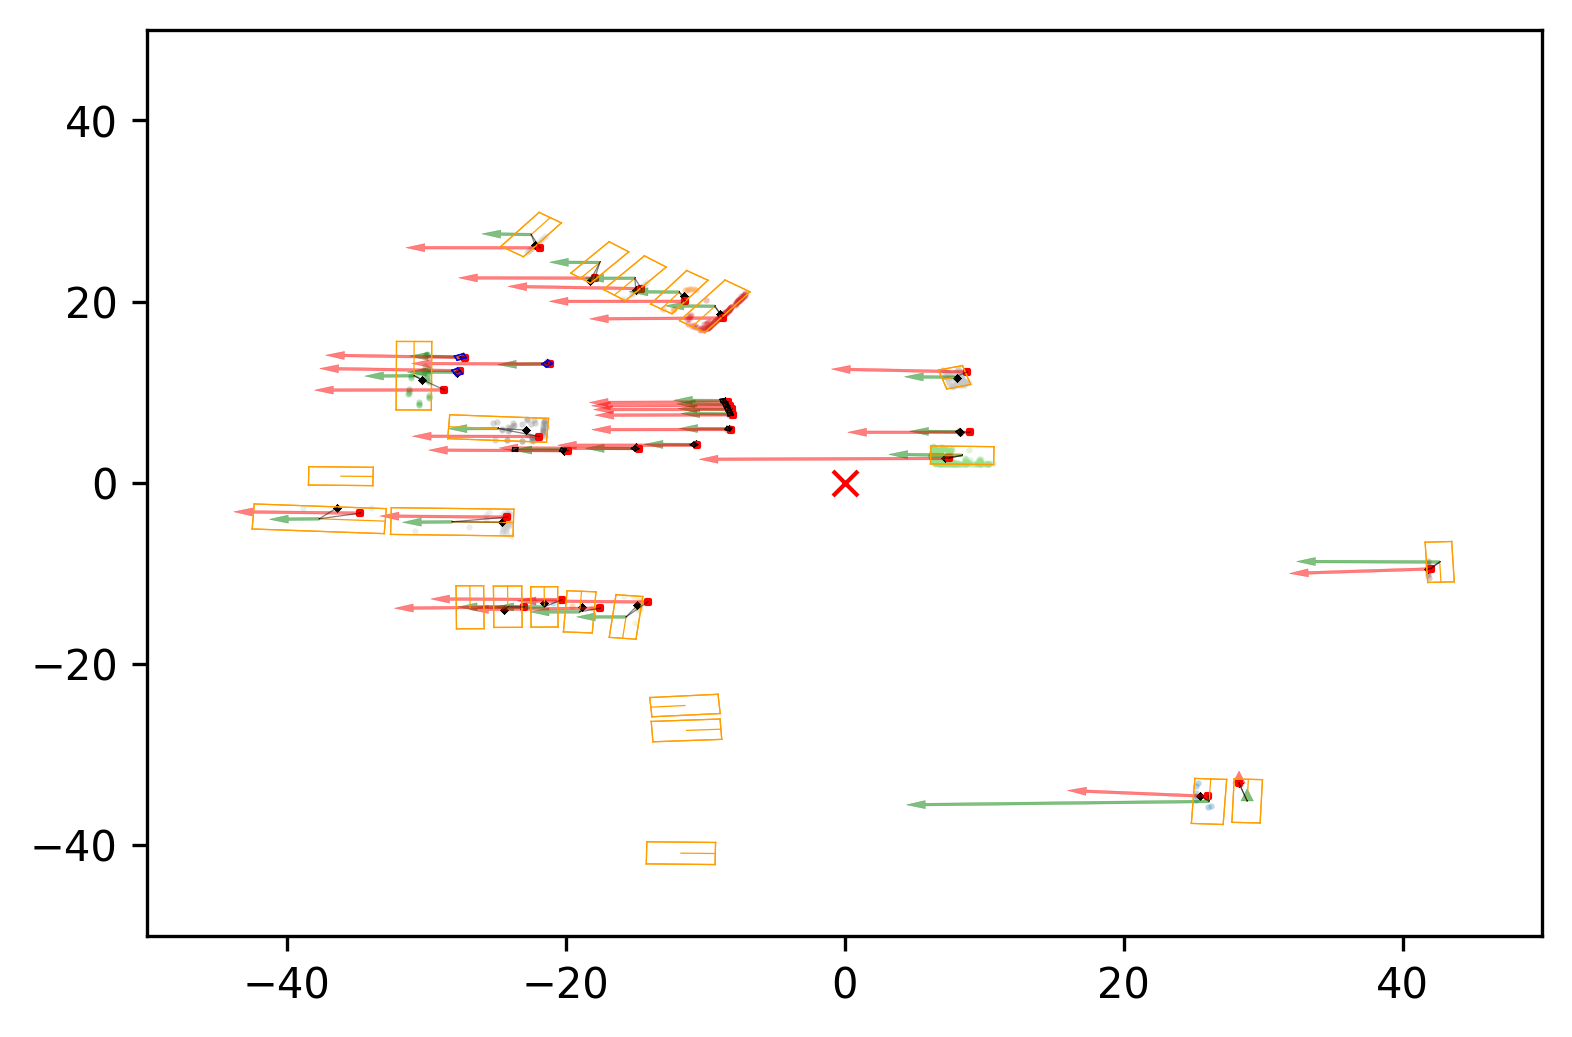

rendered sample_token_index 40


In [31]:
annots = predict_position_and_velocity(dpi=300, wait=0, transition_error_sigma=1e-100, measurement_error_sigma=1e-5)

In [32]:
png2mp4(3)